# Retrieval Augmented Generation

## Initial Setup

In [40]:
# !brew install wget

In [1]:
## Set HuggingFace token
# You need to set the HuggingFace token and save it inside the .env file. Save it as HF_TOKEN=your_token_here.

In [2]:
# echo "TOKENIZERS_PARALLELISM = false" >> .env

In [43]:
# !brew install poppler

In [44]:
# !echo "OCR_AGENT=unstructured.partition.utils.ocr_models.tesseract_ocr.OCRAgentTesseract" >> .env

In [3]:
import os, json, re, getpass, warnings
import numpy as np
from dotenv import load_dotenv
from uuid import uuid4
from IPython.display import display, Markdown

In [4]:
warnings.filterwarnings('ignore')
load_dotenv(override=True)

True

In [5]:
#Check for Groq API Key
if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("GROQ API Key: ")

In [7]:
#Set Hugging Face token (as we will be using some of Hugging Face's functionalities
from huggingface_hub.hf_api import HfFolder
HfFolder.save_token(os.environ["HF_TOKEN"])

In [10]:
np.__version__

'2.2.6'

## Part 1: Indexing

In [11]:
# Question
question = "What is TrueFoundry all about?"

### Concept: Tokenization

**tiktoken** is a fast BPE tokenizer for use with OpenAI's models. It takes a 1) text string and 2) encoding to convert string to tokens.

**About encodings:** Encodings specify how text is converted into tokens. Different models use different encodings. 

`tiktoken` supports following encodings used by OpenAI models:

| Encoding name | OpenAI models |
|---|---|
| `o200k_base` | gpt-4o, gpt-4o-mini |
| `cl100k_base` | gpt-4-turbo, gpt-4, gpt-3.5-turbo, text-embedding-ada-002, text-embedding-3-small, text-embedding-3-large |
| `p50k_base` | Codex models, text-davinci-002, text-davinci-003 |
| `r50k_base` (or `gpt2`) | GPT-3 models like davinci |

**Note:** You can check out how a string is tokenized using the third-party [Tiktokenizer](https://tiktokenizer.vercel.app/) app. 

In [11]:
#Import library
import tiktoken

In [12]:
#Load an encoding - load encoding by name 
encoding = tiktoken.get_encoding("cl100k_base")

In [13]:
#Load an encoding - load encoding for a model 
encoding = tiktoken.encoding_for_model("gpt-4o-mini")

In [14]:
#Turn text into tokens
tokens = encoding.encode(question)
tokens

[4827, 382, 6432, 7818, 1102, 722, 1078, 30]

In [15]:
len(tokens)

8

In [16]:
#Count tokens
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    tokens = encoding.encode(string)
    num_tokens = len(tokens)
    return num_tokens

In [17]:
num_tokens_from_string(question, "cl100k_base")

8

In [18]:
#Decode list of token integers to string
encoding.decode(tokens)

'What is TrueFoundry all about?'

#### What about non-OpenAI models?

 Use AutoTokenizer class from Hugging Face `transformers` library.

**Important points**:
- Make sure you have have created token and logged into Hugging Face Hub.
- Please ensure the model name is correct; if it's a gated model, you might need get access from the model page on Hugging Face Hub.
    - Access to model meta-llama/Llama-3.1-8B is restricted by default, in our example. Visit https://huggingface.co/meta-llama/Llama-3.1-8B to ask for access.

In [19]:
from transformers import AutoTokenizer

In [20]:
#Model name should be as per Hugging Face - exact name can differ from the model name in Ollama/Groq, for example
model_name = "meta-llama/Llama-3.1-8B"

In [21]:
# Load the tokenizer for the specified Llama 3.2 model.
# `trust_remote_code=True` is often necessary for custom model architectures.
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

In [22]:
# Tokenize the input text.
# `add_special_tokens=False` can be used if you only want to count content tokens
# without BOS/EOS tokens, but typically for LLM usage, special tokens are included.
tokens = tokenizer.encode(question, add_special_tokens=True)
tokens

[128000, 3923, 374, 3082, 6788, 894, 682, 922, 30]

In [23]:
len(tokens)

9

**Note**: Typically, we do not need to tokenize the text beforehand when using any embedding model. Most other embedding models from libraries like LangChain or directly from model providers handle the tokenization internally as part of its process to generate the embeddings!

### Concept: Embedding

Conceptual Reference - [Embedding models](https://python.langchain.com/docs/concepts/embedding_models/)

Check out this MTEB leaderboard for benchmarking embedding models: [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard) 

You can choose different embedding models based on 
1) Embedding dimension
2) Max tokens supported
3) Performance/accuracy (on specific tasks)
4) Multilinguality/Language Support
5) Model Size and Inference Speed/Efficiency
6) Licensing and Usage Restrictions
7) Cost (for API-based, like OpenAI)

In [24]:
!ollama pull llama3.2

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest 
pulling dde5aa3fc5ff: 100% ▕██████████████████▏ 2.0 GB                         
pulling 966de95ca8a6: 100% ▕██████████████████▏ 1.4 KB                         
pulling fcc5a6bec9da: 100% ▕██████████████████▏ 7.7 KB                         
pulling a70ff7e570d9: 100% ▕██████████████████▏ 6.0 KB                         
pulling 56bb8bd477a5: 100% ▕██████████████████▏   96 B                         
pulling 34bb5ab01051: 100% ▕██████████████████▏  561 B                         
verifying sha256 digest 
writing manifest 
success 


In [25]:
from langchain_ollama import OllamaEmbeddings

embeddings_model = OllamaEmbeddings(model="llama3.2")

**Benefit of LangChain**: It provides a universal interface for working with embedding models. The two central methods are:

- `embed_documents`: for embedding multiple texts (documents)
- `embed_query`: for embedding a single text (query)

In [26]:
embeddings = embeddings_model.embed_documents(
    [
        "Hi there!",
        "We are studying Agentic AI today.",
        "How's the weather?",
        "TrueFoundry's GHQ is situated in San Francisco.",
        "Hello there!"
    ]
)

In [27]:
#Embedding is a list of lists - so we convert to a NumPy array to see shape
np.array(embeddings).shape

(5, 3072)

In [28]:
query_embedding = embeddings_model.embed_query(question)

In [29]:
#Embedding is now a list - still we convert to a NumPy array to see shape
np.array(query_embedding).shape

(3072,)

#### Calculating Similarity

There are 3 common metrics used to measure similarity:

- Cosine similarity (opposite of cosine distance)
- Euclidean distance
- Dot product

Choice of similarity metric depends on the model, for example, [OpenAI suggests to use cosine similarity](https://platform.openai.com/docs/guides/embeddings/which-distance-function-should-i-use) as the primary metric. However, all the 3 metrics are similar in some aspects, so choice of metric is not a major consideration in general (see article from Google [here](https://developers.google.com/machine-learning/clustering/dnn-clustering/supervised-similarity) that demonstrates proportionality of similarity measures).

In [30]:
#Sample code for cosine similarity
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

In [31]:
question

'What is TrueFoundry all about?'

In [32]:
query_1_embedding = embeddings_model.embed_query("TrueFoundry provides a low latency enterprise AI Gateway with MCP server integrations, guardrails, observability, latency based routing, model fallback, caching, quota and access control (on-premise, VPC or cloud).The company also provides a robust enterprise LLMOPs Platform for model serving, inference and efficient finetuning.")
query_2_embedding = embeddings_model.embed_query("What is TrueFoundry all about?")

In [33]:
similarity = cosine_similarity(query_1_embedding, query_2_embedding)
print("Cosine Similarity:", similarity)

Cosine Similarity: 0.5825017301886483


It has a high cosine similarity, as expected.

**Question**: 
- What is the min and max of cosine similarity metric?
- What about dot product (inner product)?
- What about euclidean distance?

### Loading Documents

Reference - [Document Loaders](https://python.langchain.com/docs/integrations/document_loaders/)

**What is Beautiful Soup?** It is a library used to scrape information from web pages. It uses an HTML or XML parser under the hood!

In [34]:
import bs4 #import Beautiful Soup
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [35]:
# Only keep the main content from the full HTML
bs4_strainer = bs4.SoupStrainer(class_=("section_gateway-banner ai", 
                                        "section_traces-features ai_gateway",
                                       "section_home-ai"))
loader = WebBaseLoader(
    web_paths=("https://www.truefoundry.com/ai-gateway", 
               "https://www.truefoundry.com"),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 2

print(f"Total characters: {len(docs[0].page_content)}")
print(docs[0].page_content) # Print a snippet to verify

Total characters: 3583


Secure Deployment : VPC | On-Prem | Air-GappedAI Gateway: Fast, Scalable, Enterprise-ReadyEnterprise-Ready AI Gateway for secure, high-performance LLM access, observability, and orchestration.See detailed pricingGet Started for FreeAI Gateway: Unified LLM API AccessSimplify your GenAI stack with a single AI Gateway that integrates all major models.

Connect to OpenAI, Claude, Gemini, Groq, Mistral, and 250+ LLMs through one AI Gateway API

Use the platform to support chat, completion, embedding, and reranking model types.

Centralize API key management and team authentication in one place.

Orchestrate multi-model workloads seamlessly through your infrastructure.Read MoreAI Gateway Observability

Monitor token usage, latency, error rates, and request volumes across your system.

Store and inspect full request/response logs centrally to ensure compliance and simplify debugging.

Tag traffic with metadata like user ID, team, or environment to gain granular insigh

In [36]:
print(f"Total characters: {len(docs[1].page_content)}")
print(docs[1].page_content) # Print a snippet to verify

Total characters: 649
Orchestrate Agentic AI with AI GatewayEnable intelligent multi-step reasoning, tool usage, and memory with full control and visibility across your AI agents and workflows.AI GatewayManage agent memory, tool orchestration, and action planning through a centralized protocol that supports complex, context-aware workflows.Learn More

MCP & Agents RegistryMaintain a structured, discoverable registry of tools and APIs accessible to agents, complete with schema validation and access control.Learn More

Prompt Lifecycle ManagementVersion, manage, and monitor prompts to ensure high-quality, repeatable behavior across agents and use cases.Learn More




In [37]:
# --- Post-processing to clean up excessive newlines and whitespace ---
for i, doc in enumerate(docs):
    if doc.page_content:
        # 1. Replace multiple newlines with a single newline
        cleaned_content = re.sub(r'\n\s*\n', '\n\n', doc.page_content)
        # 2. Replace multiple spaces with a single space
        cleaned_content = re.sub(r' {2,}', ' ', cleaned_content)
        # 3. Strip leading/trailing whitespace from each line
        cleaned_content = '\n'.join([line.strip() for line in cleaned_content.split('\n')])
        # 4. Remove leading/trailing whitespace from the whole string
        cleaned_content = cleaned_content.strip()
    
        docs[i].page_content = cleaned_content
# --- End of post-processing ---

In [38]:
print(f"Total characters: {len(docs[0].page_content)}")
print("\n--- Cleaned Content Snippet ---")
print(docs[0].page_content) # Print a snippet to verify

Total characters: 3581

--- Cleaned Content Snippet ---
Secure Deployment : VPC | On-Prem | Air-GappedAI Gateway: Fast, Scalable, Enterprise-ReadyEnterprise-Ready AI Gateway for secure, high-performance LLM access, observability, and orchestration.See detailed pricingGet Started for FreeAI Gateway: Unified LLM API AccessSimplify your GenAI stack with a single AI Gateway that integrates all major models.

Connect to OpenAI, Claude, Gemini, Groq, Mistral, and 250+ LLMs through one AI Gateway API

Use the platform to support chat, completion, embedding, and reranking model types.

Centralize API key management and team authentication in one place.

Orchestrate multi-model workloads seamlessly through your infrastructure.Read MoreAI Gateway Observability

Monitor token usage, latency, error rates, and request volumes across your system.

Store and inspect full request/response logs centrally to ensure compliance and simplify debugging.

Tag traffic with metadata like user ID, team, or envi

In [39]:
print(f"Total characters: {len(docs[0].page_content)}")
print("\n--- Cleaned Content Snippet ---")
print(docs[0].page_content[:1000]) # Print a snippet to verify

Total characters: 3581

--- Cleaned Content Snippet ---
Secure Deployment : VPC | On-Prem | Air-GappedAI Gateway: Fast, Scalable, Enterprise-ReadyEnterprise-Ready AI Gateway for secure, high-performance LLM access, observability, and orchestration.See detailed pricingGet Started for FreeAI Gateway: Unified LLM API AccessSimplify your GenAI stack with a single AI Gateway that integrates all major models.

Connect to OpenAI, Claude, Gemini, Groq, Mistral, and 250+ LLMs through one AI Gateway API

Use the platform to support chat, completion, embedding, and reranking model types.

Centralize API key management and team authentication in one place.

Orchestrate multi-model workloads seamlessly through your infrastructure.Read MoreAI Gateway Observability

Monitor token usage, latency, error rates, and request volumes across your system.

Store and inspect full request/response logs centrally to ensure compliance and simplify debugging.

Tag traffic with metadata like user ID, team, or envi

#### Other Useful Loaders - UnstructuredPDFLoader (Example Implementation)

[Portable Document Format (PDF)](https://en.wikipedia.org/wiki/PDF), standardized as ISO 32000, is a file format developed by Adobe in 1992 to present documents, including text formatting and images, in a manner independent of application software, hardware, and operating systems.

LangChain integrates with a host of PDF parsers. Some are simple and relatively low-level; others will support OCR and image-processing, or perform advanced document layout analysis. The right choice will depend on your use-case and through experimentation.

Here we will see how to load PDF documents into the LangChain `Document` format

We download a research paper to experiment with.

In [12]:
!wget -O 'layoutparser_paper.pdf' 'http://arxiv.org/pdf/2103.15348.pdf'

--2025-09-13 13:58:24--  http://arxiv.org/pdf/2103.15348.pdf
Resolving arxiv.org (arxiv.org)... 151.101.195.42, 151.101.67.42, 151.101.3.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.195.42|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://arxiv.org/pdf/2103.15348.pdf [following]
--2025-09-13 13:58:24--  https://arxiv.org/pdf/2103.15348.pdf
Connecting to arxiv.org (arxiv.org)|151.101.195.42|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /pdf/2103.15348 [following]
--2025-09-13 13:58:24--  https://arxiv.org/pdf/2103.15348
Reusing existing connection to arxiv.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 4686220 (4.5M) [application/pdf]
Saving to: ‘layoutparser_paper.pdf’

layoutparser_paper. 100%[===================>]   4.47M  20.9MB/s    in 0.2s    

2025-09-13 13:58:25 (20.9 MB/s) - ‘layoutparser_paper.pdf’ saved [4686220/4686220]



**UnstructuredPDFLoader**

[Unstructured.io](https://unstructured-io.github.io/unstructured/) supports a common interface for working with unstructured or semi-structured file formats, such as Markdown or PDF. LangChain's [`UnstructuredPDFLoader`](https://api.python.langchain.com/en/latest/document_loaders/langchain_community.document_loaders.pdf.UnstructuredPDFLoader.html) integrates with Unstructured to parse PDF documents into LangChain [`Document`](https://api.python.langchain.com/en/latest/documents/langchain_core.documents.base.Document.html) objects.

In [13]:
from langchain_community.document_loaders import UnstructuredPDFLoader

In [45]:
#This takes 3-4 minutes to run
loader = UnstructuredPDFLoader('./layoutparser_paper.pdf',
                               strategy='hi_res',
                               extract_images_in_pdf=True,
                               infer_table_structure=True,
                               chunking_strategy="by_title", # section-based chunking
                               max_characters=4000, # max size of chunks
                               new_after_n_chars=3800, # preferred size of chunks
                               combine_text_under_n_chars=2000, # smaller chunks < 2000 chars will be combined into a larger chunk
                               mode='elements')
data = loader.load()

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [46]:
len(data)

16

In [47]:
[doc.metadata['category'] for doc in data]

['CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement']

In [48]:
data[0]

Document(metadata={'source': './layoutparser_paper.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2023-01-23T14:45:33', 'page_number': 1, 'orig_elements': 'eJy9V11v3DYW/SvceUqKkapvjfxSOzGwSevuBom7XdQNDEq6mmEiiQJJjTPJ9r/vITnjTBK3QA3YTzOkeD/PufeSV58W1NNAo7kW7eKELaqyzIquqQLO81WQNUkb1CWPg2aVJjWWWVTyxZItBjK85YZD5tOikVK1YuSGtFv3fCdnc70hsd4Y7CRJFEFmv30jWrPBbly63UmK0Vi5q6usCPMly/MszN4u2X4ZR2kSxnZdlWH07dofx3qhd9rQYKN4JT5Q/2biDS3+wIeWDDVGyPG66bnW15OSNY5FYV5kRYwDnejJ7CZysq9+Xjhnx/XM1y6iqwWN68Vbt6vN9SBb0Qly+UqiJA2iOEjSyzg7yfKTNLXSEySvx3moSdlIrROGPthcLK4aHT7/z1uWxOzHeWRQEFuJg/kXxFsIQeJraCiv467siiCJMh5kqYWmWuFf06V5wiNquvbBoMkjn/sqDyOb+/06z1O/Xq3uXPvzfwnOY+Y+AXnCOE+z1TZhXP1XbI9T/8vYIE9rqcRHai+tyF0ocE6UFklQ1VmN3OdVgLqogrzt4qLMqKjqh0MhS3NbEmm8CleuQvw6iyqf9Tgpc5v3bza8xD2LJCvT1SMDdeEy8YorTeqEnbFfRqeMXUrZvxeGdVKxc6KJXRBXoxjX7BnX+H4um9mCxV4OUM7ORt7vtNDHKF8K09OdyIKtdZQWQRlncZCtqlWwyss0sKAWdb5Kqix5MGTTwhVMVsa+t+3XoGqYOCDTLA7LOza8xD2RrfKieGRkf6N3ArrZmw2N/2BPsqdL9nqWDVbstw0+/D4nUd

In [49]:
print(data[1].page_content)

1 Introduction

Deep Learning(DL)-based approaches are the state-of-the-art for a wide range of document image analysis (DIA) tasks including document image classification

2 Z. Shen et al.

table detection [37], layout de and scene text detection [4]. A generalized learning-based framework dramatically reduces the need for the manual specification of complicated rules, which is the status quo with traditional methods. DL has the potential to transform DIA pipelines and benefit a broad spectrum of large-scale document digitization projects.

However, there are several practical difficulties for taking advantages of re- cent advances in DL-based methods: 1) DL models are notoriously convoluted for reuse and extension. Existing models are developed using distinct frame- works like TensorFlow [I] or PyTorch be obfuscated by implementation details and the high-level parameters can . It can be a time-consuming and frustrating experience to debug, reproduce, and adapt existing models for DIA

In [50]:
! ls -l ./figures

total 648
-rw-r--r--@ 1 anantagarwal  staff  84771 10 Sep 14:04 figure-10-4.jpg
-rw-r--r--@ 1 anantagarwal  staff  41639 10 Sep 14:04 figure-11-5.jpg
-rw-r--r--@ 1 anantagarwal  staff  62560 10 Sep 14:04 figure-13-6.jpg
-rw-r--r--@ 1 anantagarwal  staff  36497 10 Sep 14:04 figure-4-1.jpg
-rw-r--r--@ 1 anantagarwal  staff  29862 10 Sep 14:04 figure-6-2.jpg
-rw-r--r--@ 1 anantagarwal  staff  64442 10 Sep 14:04 figure-9-3.jpg


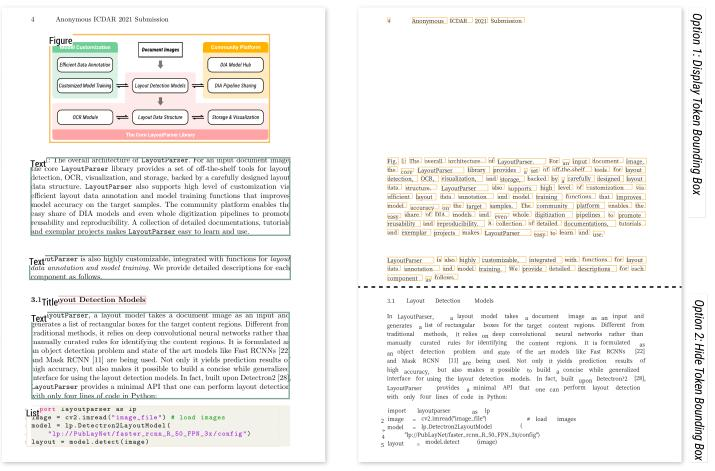

In [51]:
from IPython.display import Image

Image('./figures/figure-9-3.jpg')

### Splitting Documents

**Overview**

* **Goal of Chunking:** Optimize data for effective future retrieval

* **Character Splitting**: Divides text into fixed N-character chunks, ignoring content or structure. However, it's very rigid; disregards text structure, making it generally not recommended.

* **Recursive Character Text Splitting**: Addresses character splitting's rigidity by using a series of specified separators to split documents, considering their structure. This is a versatile "swiss army knife" approach, often the first choice for quick applications. Some default Separators (e.g., in LangChain):

    * `"\n\n"`: Double newlines (paragraph breaks).
    * `"\n"`: Single newlines.
    * `" "` : Spaces.
    * `""` : Individual characters.

* **Hyperparameters (should be tuned!):**
  * **Chunk Size:** The desired number of characters per chunk (e.g., 50, 100). (**not tokens!**)
  * **Chunk Overlap:** The amount sequential chunks overlap to avoid context breaks, creating duplicate data (e.g., if chunk 1 is chars 1-100, chunk 2 might be 81-180 with 20 overlap).


**More References**

Check out this nice visualization to understand Character Splitting and Recursive Character Text Splitting - https://chunkviz.up.railway.app/

Reference (LangChain) - [Text Splitters](https://python.langchain.com/docs/concepts/text_splitters/)

Overview of popular methods: 

| Splitter Type              | Description                                                                                                                              |
| :------------------------- | :--------------------------------------------------------------------------------------------------------------------------------------- |
| `RecursiveCharacterTextSplitter` | Recursively splits text into larger chunks based on several defined characters. Tries to keep related pieces of text next to each other. LangChain's recommended way to start splitting text |
| `CharacterTextSplitter`    | Splits text based on a user defined character. One of the simpler text splitters                                                         |
| `tiktoken`                 | Splits text based on tokens using trained LLM tokenizers like GPT-4                                                                      |
| `spaCy`                    | Splits text using the tokenizer from the popular NLP library - `spaCy`                                                                   |
| `SentenceTransformers`     | Splits text based on tokens using trained open LLM tokenizers available from the popular `sentence-transformers` library                 |
| `unstructured.io`          | The unstructured library allows various splitting and chunking strategies including splitting text based on key sections and titles      |

#### Recursive Character Text Splitter

In [52]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters) - hyperparameter that can be tuned
    chunk_overlap=200,  # chunk overlap (characters) - hyperparameter that can be tuned
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 6 sub-documents.


In [53]:
for i in range(len(all_splits)):
    print(f"\n--- Split{i} ---\n")
    print(all_splits[i].page_content)


--- Split0 ---

Secure Deployment : VPC | On-Prem | Air-GappedAI Gateway: Fast, Scalable, Enterprise-ReadyEnterprise-Ready AI Gateway for secure, high-performance LLM access, observability, and orchestration.See detailed pricingGet Started for FreeAI Gateway: Unified LLM API AccessSimplify your GenAI stack with a single AI Gateway that integrates all major models.

Connect to OpenAI, Claude, Gemini, Groq, Mistral, and 250+ LLMs through one AI Gateway API

Use the platform to support chat, completion, embedding, and reranking model types.

Centralize API key management and team authentication in one place.

Orchestrate multi-model workloads seamlessly through your infrastructure.Read MoreAI Gateway Observability

Monitor token usage, latency, error rates, and request volumes across your system.

Store and inspect full request/response logs centrally to ensure compliance and simplify debugging.

Tag traffic with metadata like user ID, team, or environment to gain granular insights.

---

#### Semantic Text Splitter (custom innovation)

Innovated by Greg Kamradt [here](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb), and adapted by both LangChain and Llamaindex!

Semantic chunking splits text into coherent segments based on semantic similarity. It works by initially splitting text into sentences, then grouping them into groups of 3, and finally merging those groups whose embeddings are semantically close.

In [54]:
from langchain_experimental.text_splitter import SemanticChunker

In [55]:
#Create text splitter
text_splitter_semantic = SemanticChunker(embeddings_model)

In [56]:
len(docs[1].page_content)

647

In [57]:
#Reduce content of second doc for faster runtimes
from langchain_core.documents import Document
docs_truncated = docs.copy()
docs_truncated[1] = Document(page_content= docs[1].page_content[:5000], metadata=docs[1].metadata)

In [58]:
#Split the documents into chunks (only pick second one)
all_splits_semantic = text_splitter_semantic.split_documents(docs_truncated)
print(f"Split input into {len(all_splits_semantic)} sub-documents.")

Split input into 4 sub-documents.


In [59]:
for i in range(len(all_splits_semantic)):
    print(f"\n--- Split{i} ---\n")
    print(all_splits_semantic[i].page_content)


--- Split0 ---

Secure Deployment : VPC | On-Prem | Air-GappedAI Gateway: Fast, Scalable, Enterprise-ReadyEnterprise-Ready AI Gateway for secure, high-performance LLM access, observability, and orchestration.See detailed pricingGet Started for FreeAI Gateway: Unified LLM API AccessSimplify your GenAI stack with a single AI Gateway that integrates all major models. Connect to OpenAI, Claude, Gemini, Groq, Mistral, and 250+ LLMs through one AI Gateway API

Use the platform to support chat, completion, embedding, and reranking model types. Centralize API key management and team authentication in one place. Orchestrate multi-model workloads seamlessly through your infrastructure.Read MoreAI Gateway Observability

Monitor token usage, latency, error rates, and request volumes across your system. Store and inspect full request/response logs centrally to ensure compliance and simplify debugging. Tag traffic with metadata like user ID, team, or environment to gain granular insights. Filter lo

In [60]:
#Remember that the entire document has been split into smaller documents (which we are calling chunks!)
type(all_splits_semantic[0])

langchain_core.documents.base.Document

**This is much better, as we inspect on the homepage!** Note, that this method requires the use of a embedding model and is relatively much slower!

### Storing Documents in Vector Store

Conceptual Reference - [Vector stores](https://python.langchain.com/docs/concepts/vectorstores/)

#### FAISS

**Facebook AI Similarity Search (FAISS)** is one of the popular implementations of *efficient similarity search*. It allows us to build an index and search, but it *speeds up search times to high performance levels*.

In [85]:
#Import libraries
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

In [86]:
#To get the dimension of the embedding generated by the model
print(question)
query_embedding = embeddings_model.embed_query(question)
len(query_embedding)

What is TrueFoundry all about?


3072

In [87]:
#Initialize the index (using the basic IndexFlatL2 - there are IndexIVFFlat and IndexIVFPQ also available that're faster. Note the tradeoff between accuracy and speed)
index = faiss.IndexFlatL2(len(query_embedding))

In [88]:
#Create a vector store
vector_store_faiss = FAISS(
    embedding_function=embeddings_model,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

In [89]:
len(all_splits_semantic)

4

In [90]:
all_splits_semantic

[Document(metadata={'source': 'https://www.truefoundry.com/ai-gateway'}, page_content='Secure Deployment : VPC | On-Prem | Air-GappedAI Gateway: Fast, Scalable, Enterprise-ReadyEnterprise-Ready AI Gateway for secure, high-performance LLM access, observability, and orchestration.See detailed pricingGet Started for FreeAI Gateway: Unified LLM API AccessSimplify your GenAI stack with a single AI Gateway that integrates all major models. Connect to OpenAI, Claude, Gemini, Groq, Mistral, and 250+ LLMs through one AI Gateway API\n\nUse the platform to support chat, completion, embedding, and reranking model types. Centralize API key management and team authentication in one place. Orchestrate multi-model workloads seamlessly through your infrastructure.Read MoreAI Gateway Observability\n\nMonitor token usage, latency, error rates, and request volumes across your system. Store and inspect full request/response logs centrally to ensure compliance and simplify debugging. Tag traffic with metada

In [91]:
#Add all chunks to vector DB
uuids = [str(uuid4()) for _ in range(len(all_splits_semantic))] #Universally unique identifier
vector_store_faiss.add_documents(documents=all_splits_semantic, ids=uuids)

['86e62ba2-b0da-4650-bf69-afe04eff2ff7',
 'c6fca6fb-8dcf-4d64-b864-bd69487f9553',
 '910f20f9-355f-480a-8a68-8a0d7f6dedff',
 '60d3059f-5e7b-4d54-a30d-b5af61834e44']

Although we can directly query by using `similarity_search` method of the `vector_store`, we will turn the vector store into a retriever and then use it, as it'll lead to easier usage when building our chains.

**Why?** Because, both will be *Runnable* objects then!

#### ChromaDB

ChromaDB stands out as a *developer-friendly* and *open-source* vector database. Unlike FAISS, which is primarily a library for efficient similarity search, ChromaDB offers a **complete, ready-to-use solution** for storing, indexing, and querying embeddings, with built-in support for common embedding models and a Python client for ease of use.

In [92]:
#Import library
from langchain_chroma import Chroma

In [93]:
#Create a vector store
vector_store_chroma = Chroma(
    collection_name="rag-primer",
    embedding_function=embeddings_model,
    # persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

In [94]:
#Add all chunks to vector DB
uuids = [str(uuid4()) for _ in range(len(all_splits_semantic))] #Universally unique identifier
vector_store_chroma.add_documents(documents=all_splits_semantic, ids=uuids)

['dc25f487-c553-4356-8667-300534248c56',
 'cd792498-d814-4592-bad1-dc5e9c53d635',
 '6ce0b959-0cf4-4d50-b0bc-32715e3d51f5',
 'ca06b555-ce40-47cc-9c7a-589e51a2e25e']

**Question 1**

I have a document of 1M words. Consider each word as having 20 characters exactly and 1 space between each word. I am chunking it using a max chunk size of 100 characters. How many minimum chunks will I have? (consider 1 word = 1.33 tokens)

Min number of chunks  = (20 characters + 1 character)*1M words / (100 characters per chunk) = 0.21M chunks

*Max number of chunks  = 21M chunks*

**Question 2**

What will be the embedding matrix size assuming min chunks? (d = 4096)

(0.21M x 4096)

**Question 3**
Consider my user prompt of 1000 words, and I am putting my complete document (=10,000 words) in the context and passing it to an LCM. Consider system prompt as "You are a strong AI/ML researcher". No memory. Input token cost = $0.4/1M tokens and output token cost = $1.6/1M tokens. Output = 50 words.

We are using GPT4.1 mini which has a context length of 128,000 tokens and max_tokens as 4096 tokens.

1) Is it possible?
2) Cost?

**Answer 1**
(i)
Input words = 1000 words (user prompt) + 10,000 words (complete document) + 6 words (system prompt)
Output words = 50 words
Total words = 11,056 words
Total tokens = 11,056* 1.33 = 14,705 tokens << 128,000 token context length

(ii) Output = 50 words * 1.33 = 66.5 tokens << 4096 token max tokens

**Answer 2**

Input tokens = 11,006 * 1.33 = 14,638 tokens
Input cost = 14,638 * 0.4 / 1,000,000 = $0.0058 = ~Rs. 0.5

Output tokens = 66.5
Output cost = 66.5 *1.6/1,000,000 = $0.00011 = ~Rs.0.008

## Part 2: Retrieval and Generation

In [95]:
#Printing our main question
question

'What is TrueFoundry all about?'

In [96]:
#Also having one out of context question
question_out_of_context = "Portkey and LiteLLM are competitors of TrueFoundry - is that true?"

### Retrieval

#### Retrieval Based On Semantic Similarity Search

The vector store can be directly queried using `similarity_search` method. However, we will turn the vector store to a retriever using `as_retriever` method, and then use it. Benefit is that the resulting retriever is a *Runnable* object, making it easier to use with chains!

In [97]:
#Create retriever from vector store
retriever = vector_store_chroma.as_retriever()

In [98]:
type(retriever)

langchain_core.vectorstores.base.VectorStoreRetriever

In [99]:
#Check default settings
docs = retriever.invoke(question)
docs

[Document(id='dc25f487-c553-4356-8667-300534248c56', metadata={'source': 'https://www.truefoundry.com/ai-gateway'}, page_content='Secure Deployment : VPC | On-Prem | Air-GappedAI Gateway: Fast, Scalable, Enterprise-ReadyEnterprise-Ready AI Gateway for secure, high-performance LLM access, observability, and orchestration.See detailed pricingGet Started for FreeAI Gateway: Unified LLM API AccessSimplify your GenAI stack with a single AI Gateway that integrates all major models. Connect to OpenAI, Claude, Gemini, Groq, Mistral, and 250+ LLMs through one AI Gateway API\n\nUse the platform to support chat, completion, embedding, and reranking model types. Centralize API key management and team authentication in one place. Orchestrate multi-model workloads seamlessly through your infrastructure.Read MoreAI Gateway Observability\n\nMonitor token usage, latency, error rates, and request volumes across your system. Store and inspect full request/response logs centrally to ensure compliance and 

In [100]:
question

'What is TrueFoundry all about?'

**Now let's pass a search parameter, that retrieves based on similarity score threshold.**

In [107]:
#Create retriever from vector store with similarity score threshold
retriever = vector_store_chroma.as_retriever(
    search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.01}  # hyperparameter that can be tuned
)

In [108]:
docs = retriever.invoke(question)
docs

[Document(id='dc25f487-c553-4356-8667-300534248c56', metadata={'source': 'https://www.truefoundry.com/ai-gateway'}, page_content='Secure Deployment : VPC | On-Prem | Air-GappedAI Gateway: Fast, Scalable, Enterprise-ReadyEnterprise-Ready AI Gateway for secure, high-performance LLM access, observability, and orchestration.See detailed pricingGet Started for FreeAI Gateway: Unified LLM API AccessSimplify your GenAI stack with a single AI Gateway that integrates all major models. Connect to OpenAI, Claude, Gemini, Groq, Mistral, and 250+ LLMs through one AI Gateway API\n\nUse the platform to support chat, completion, embedding, and reranking model types. Centralize API key management and team authentication in one place. Orchestrate multi-model workloads seamlessly through your infrastructure.Read MoreAI Gateway Observability\n\nMonitor token usage, latency, error rates, and request volumes across your system. Store and inspect full request/response logs centrally to ensure compliance and 

In [109]:
print(docs[0].page_content)

Secure Deployment : VPC | On-Prem | Air-GappedAI Gateway: Fast, Scalable, Enterprise-ReadyEnterprise-Ready AI Gateway for secure, high-performance LLM access, observability, and orchestration.See detailed pricingGet Started for FreeAI Gateway: Unified LLM API AccessSimplify your GenAI stack with a single AI Gateway that integrates all major models. Connect to OpenAI, Claude, Gemini, Groq, Mistral, and 250+ LLMs through one AI Gateway API

Use the platform to support chat, completion, embedding, and reranking model types. Centralize API key management and team authentication in one place. Orchestrate multi-model workloads seamlessly through your infrastructure.Read MoreAI Gateway Observability

Monitor token usage, latency, error rates, and request volumes across your system. Store and inspect full request/response logs centrally to ensure compliance and simplify debugging. Tag traffic with metadata like user ID, team, or environment to gain granular insights. Filter logs and metrics by

**Now let's pass another search parameter, that retrieves top k results only.**

In [110]:
#Create retriever from vector store with similarity score threshold
retriever = vector_store_chroma.as_retriever(
    search_kwargs={"k": 3} # hyperparameter that can be tuned
)

In [111]:
docs = retriever.invoke(question)
docs

[Document(id='dc25f487-c553-4356-8667-300534248c56', metadata={'source': 'https://www.truefoundry.com/ai-gateway'}, page_content='Secure Deployment : VPC | On-Prem | Air-GappedAI Gateway: Fast, Scalable, Enterprise-ReadyEnterprise-Ready AI Gateway for secure, high-performance LLM access, observability, and orchestration.See detailed pricingGet Started for FreeAI Gateway: Unified LLM API AccessSimplify your GenAI stack with a single AI Gateway that integrates all major models. Connect to OpenAI, Claude, Gemini, Groq, Mistral, and 250+ LLMs through one AI Gateway API\n\nUse the platform to support chat, completion, embedding, and reranking model types. Centralize API key management and team authentication in one place. Orchestrate multi-model workloads seamlessly through your infrastructure.Read MoreAI Gateway Observability\n\nMonitor token usage, latency, error rates, and request volumes across your system. Store and inspect full request/response logs centrally to ensure compliance and 

**Now let's do metadata filtering.** 

A lot of vector stores also support filtering on metadata. Check more information on self-querying retrieval [here](https://python.langchain.com/docs/how_to/self_query/).

Thus, we can do both 1) **semantic search** by querying unstructured data directly 2) **metadata search** by applying structured query to metadata.

In [113]:
#Create retriever from vector store with metadata filter
retriever = vector_store_chroma.as_retriever(
    search_kwargs={"filter": {"source": "https://www.truefoundry.com"}}
)

In [114]:
# all_splits_semantic

In [115]:
docs = retriever.invoke(question)
docs

[Document(id='ca06b555-ce40-47cc-9c7a-589e51a2e25e', metadata={'source': 'https://www.truefoundry.com'}, page_content='Orchestrate Agentic AI with AI GatewayEnable intelligent multi-step reasoning, tool usage, and memory with full control and visibility across your AI agents and workflows.AI GatewayManage agent memory, tool orchestration, and action planning through a centralized protocol that supports complex, context-aware workflows.Learn More\n\nMCP & Agents RegistryMaintain a structured, discoverable registry of tools and APIs accessible to agents, complete with schema validation and access control.Learn More\n\nPrompt Lifecycle ManagementVersion, manage, and monitor prompts to ensure high-quality, repeatable behavior across agents and use cases.Learn More')]

We can see that the result from the other webpage **has been filtered out**!

#### Advanced Retrieval Based On Maximum Marginal Relevance

*Maximum marginal relevance* is a **re-ranking** algorithm that optimizes for both similarity to query *AND* diversity among selected documents. This can be used, if supported by the particular vector store.

In [116]:
#Original retrieval
for doc in docs:
    print(doc.page_content)
    print("-"*100)


Orchestrate Agentic AI with AI GatewayEnable intelligent multi-step reasoning, tool usage, and memory with full control and visibility across your AI agents and workflows.AI GatewayManage agent memory, tool orchestration, and action planning through a centralized protocol that supports complex, context-aware workflows.Learn More

MCP & Agents RegistryMaintain a structured, discoverable registry of tools and APIs accessible to agents, complete with schema validation and access control.Learn More

Prompt Lifecycle ManagementVersion, manage, and monitor prompts to ensure high-quality, repeatable behavior across agents and use cases.Learn More
----------------------------------------------------------------------------------------------------


In [117]:
retriever = vector_store_chroma.as_retriever(search_type="mmr")

In [118]:
docs = retriever.invoke(question)
docs

[Document(id='dc25f487-c553-4356-8667-300534248c56', metadata={'source': 'https://www.truefoundry.com/ai-gateway'}, page_content='Secure Deployment : VPC | On-Prem | Air-GappedAI Gateway: Fast, Scalable, Enterprise-ReadyEnterprise-Ready AI Gateway for secure, high-performance LLM access, observability, and orchestration.See detailed pricingGet Started for FreeAI Gateway: Unified LLM API AccessSimplify your GenAI stack with a single AI Gateway that integrates all major models. Connect to OpenAI, Claude, Gemini, Groq, Mistral, and 250+ LLMs through one AI Gateway API\n\nUse the platform to support chat, completion, embedding, and reranking model types. Centralize API key management and team authentication in one place. Orchestrate multi-model workloads seamlessly through your infrastructure.Read MoreAI Gateway Observability\n\nMonitor token usage, latency, error rates, and request volumes across your system. Store and inspect full request/response logs centrally to ensure compliance and 

In [119]:
#Retrieval with MMR
for doc in docs:
    print(doc.page_content)
    print("-"*100)


Secure Deployment : VPC | On-Prem | Air-GappedAI Gateway: Fast, Scalable, Enterprise-ReadyEnterprise-Ready AI Gateway for secure, high-performance LLM access, observability, and orchestration.See detailed pricingGet Started for FreeAI Gateway: Unified LLM API AccessSimplify your GenAI stack with a single AI Gateway that integrates all major models. Connect to OpenAI, Claude, Gemini, Groq, Mistral, and 250+ LLMs through one AI Gateway API

Use the platform to support chat, completion, embedding, and reranking model types. Centralize API key management and team authentication in one place. Orchestrate multi-model workloads seamlessly through your infrastructure.Read MoreAI Gateway Observability

Monitor token usage, latency, error rates, and request volumes across your system. Store and inspect full request/response logs centrally to ensure compliance and simplify debugging. Tag traffic with metadata like user ID, team, or environment to gain granular insights. Filter logs and metrics by

#### Advanced Retrieval Based On Hybrid Search

*Hybrid search* combines the benefits of both standard semantic similarity search offered by LangChain, as well as other search techniques (such as BM25, full-text and so on). We'll do **BM25+Semantic Search** in our example below and we'll make use of ChromaDB for a change.

In [120]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever

In [124]:
#Initialize BM25 retriever
bm25_retriever = BM25Retriever.from_documents(documents=all_splits_semantic)
bm25_retriever.k = 3 # Set the number of top documents to retrieve

In [125]:
#Initialize ChromaDB as a retriever
chroma_retriever = vector_store_chroma.as_retriever(search_kwargs={"k": 3})

In [126]:
#Perform reciprocal rank fusion (RRF)
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, chroma_retriever],
    weights=[0.7, 0.3]
)

In [127]:
#Perform hybrid search
docs = ensemble_retriever.invoke(question)
docs

[Document(metadata={'source': 'https://www.truefoundry.com/ai-gateway'}, page_content='Secure Deployment : VPC | On-Prem | Air-GappedAI Gateway: Fast, Scalable, Enterprise-ReadyEnterprise-Ready AI Gateway for secure, high-performance LLM access, observability, and orchestration.See detailed pricingGet Started for FreeAI Gateway: Unified LLM API AccessSimplify your GenAI stack with a single AI Gateway that integrates all major models. Connect to OpenAI, Claude, Gemini, Groq, Mistral, and 250+ LLMs through one AI Gateway API\n\nUse the platform to support chat, completion, embedding, and reranking model types. Centralize API key management and team authentication in one place. Orchestrate multi-model workloads seamlessly through your infrastructure.Read MoreAI Gateway Observability\n\nMonitor token usage, latency, error rates, and request volumes across your system. Store and inspect full request/response logs centrally to ensure compliance and simplify debugging. Tag traffic with metada

### Generation

**We'll use the advanced retrieval based on hybrid search, for our generation.**

In [128]:
#For reference
question

'What is TrueFoundry all about?'

In [129]:
#For reference
question_out_of_context

'Portkey and LiteLLM are competitors of TrueFoundry - is that true?'

#### Select the Chat Model

Conceptual Reference - [Chat models](https://python.langchain.com/docs/concepts/chat_models/)

In [130]:
from langchain.chat_models import init_chat_model

model_name = "llama-3.1-8b-instant"
llm = init_chat_model(model_name, model_provider="groq") #Other Llama alternatives available are llama3-8b-8192, llama-3.3-70b-versatile

**Question - Can we choose an embedding model that has a different dimension than the chat (generation) model used for RAG?**

#### Create custom Chat Prompt Template

In [131]:
from langchain.prompts import ChatPromptTemplate

# Prompt
template = """You are given the following information for reference:
{context}

Answer the following question:
Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='You are given the following information for reference:\n{context}\n\nAnswer the following question:\nQuestion: {question}\n'), additional_kwargs={})])

In [132]:
chain = prompt | llm

In [133]:
response = chain.invoke({"context":docs,"question":question})
display(Markdown(response.content))

Based on the provided information, TrueFoundry appears to be a company that provides an AI Gateway platform for secure, high-performance access to Large Language Models (LLMs) and other AI capabilities. The platform offers features such as:

* Unified LLM API access to connect to various models and frameworks
* Centralized API key management and team authentication
* Orchestration of multi-model workloads
* Observability and monitoring of AI traffic
* Governance and control through quota and access control
* Integration with other tools and services through MCP (Multi-Cloud Platform) support

TrueFoundry's AI Gateway seems to focus on making it easier for organizations to deploy and manage AI capabilities securely, efficiently, and scalably. The platform aims to provide a single point of access to various AI models and tools, while also offering features for monitoring, governance, and control.

In [134]:
response = chain.invoke({"context":docs,"question":question_out_of_context})
display(Markdown(response.content))

Based on the provided information, there is no mention of Portkey or LiteLLM being competitors of TrueFoundry. The information provided only includes content from TrueFoundry's website, discussing their AI Gateway and its features, but does not mention any competitors.

#### Pull Chat Prompt Template from the Hub

In [135]:
from langchain import hub
prompt_hub_rag = hub.pull("rlm/rag-prompt")
prompt_hub_rag

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

**Notice the prompt! This is how a good prompt should look like.** It explicity states to say *I don't know* if context is missing, which is a best practice.

In [136]:
chain = prompt_hub_rag | llm

In [137]:
response = chain.invoke({"context":docs,"question":question})
display(Markdown(response.content))

TrueFoundry is an AI Gateway that provides a unified interface for accessing large language models (LLMs), simplifying the deployment of generative AI (GenAI) stacks. It offers features such as secure deployment, observability, and orchestration, allowing users to centralize API key management, team authentication, and multi-model workloads. The AI Gateway also provides low-latency inference, routing and fallbacks, and integration with enterprise tools.

In [138]:
response = chain.invoke({"context":docs,"question":question_out_of_context})
display(Markdown(response.content))

I don't have information that Portkey and LiteLLM are competitors of TrueFoundry in the provided context.

#### Pull Chat Prompt Template from the Hub (and use LCEL!) - Recommended

Reference - [RAG chains](https://python.langchain.com/docs/how_to/sequence/)

In [139]:
# USE LCEL! (Recommended)
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

rag_chain = (
    {"context": ensemble_retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

response = rag_chain.invoke(question)
print(response)

Based on the provided information, TrueFoundry appears to be a company that offers an AI Gateway platform for secure, high-performance access to large language models (LLMs). The platform provides a unified API for integrating various LLMs, including OpenAI, Claude, Gemini, Groq, Mistral, and 250+ others.

TrueFoundry's AI Gateway platform seems to focus on the following key aspects:

1. **Security**: It provides a secure deployment environment, including VPC, on-prem, and air-gapped options, to ensure the confidentiality and integrity of AI workloads.
2. **Governance**: The platform offers quota and access control features to enforce governance, control costs, and reduce risk.
3. **Observability**: It provides insights into token usage, latency, error rates, and request volumes to ensure compliance and simplify debugging.
4. **Orchestration**: TrueFoundry's AI Gateway enables the orchestration of multi-model workloads, including intelligent multi-step reasoning, tool usage, and memory

In [140]:
#What is the type?
type(rag_chain)

langchain_core.runnables.base.RunnableSequence